In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import datetime
from datetime import date, timedelta
import itertools
import matplotlib.dates as mdates
from scipy.optimize import curve_fit
import matplotlib.ticker as ticker
import time

#### Figure aesthetics

In [2]:
#print(plt.style.available)
#plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')

#### Downlad data

In [3]:
def get_data():
    ##Get data from the source that is used to generate map (based on WHO official data):
    ##https://gisanddata.maps.arcgis.com/apps/opsdashboard/index.html?fbclid=IwAR0oKIKJlc-zeNZGFBVEN0-O-58daoCDaKicXwC10cjFWgCZqTPgavseTfI#/bda7594740fd40299423467b48e9ecf6
    url_confirmed = "https://raw.github.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"
    url_deaths = "https://raw.github.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv"
    url_recovered = "https://raw.github.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv"
    
    for url, data_type in zip([url_confirmed, url_deaths, url_recovered], ["confirmed", "deaths", "recovered"]):
    
        r = requests.get(url)
        filename=data_type+".csv"
        f = open(filename,'wb')
        f.write(r.content)

In [4]:
get_data()

#### Prepare dataset

In [5]:
## prepare dataset
confirmed = pd.read_csv("confirmed_man_cor.csv")
deaths = pd.read_csv("deaths_man_cor.csv")
recovered = pd.read_csv("recovered_man_cor.csv")

def reshape_single_dataset(data):
    data=data.drop(columns=["Province/State", "Lat", "Long"])
    ## aggregate data for each country
    data=data.groupby("Country/Region").sum().reset_index()
    ## reshape data
    data.reset_index(drop=True, inplace=True)
    data=data.set_index("Country/Region")
    return data

confirmed = reshape_single_dataset(confirmed)
deaths = reshape_single_dataset(deaths)
recovered = reshape_single_dataset(recovered)

In [6]:
inactive=deaths.add(recovered)
data=confirmed.subtract(inactive)

#romeve for blog
#data=confirmed

data=data.transpose().reset_index().rename(columns={'index':'Date'})
data['Date'] = pd.to_datetime(data['Date'])

#### List of countries in dataset

In [7]:
for el in data.columns:
    print(el)

Date
Poland


#### Get populations for countries in dataset

In [8]:
#data from: https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population 
#Was manually saved to csv. 
population_df=pd.read_csv("countries_population.csv",  encoding = "ISO-8859-1", header=None, usecols=[1,2], names=["country_name", "population"])
population_df

population_df['population'] = population_df['population'].apply(lambda x: str(x).replace(",", ""))
population_df['population'] = pd.to_numeric(population_df['population'], errors="coerce")

In [9]:
dictionary_country_names={
"US":"United States",
"Congo (Kinshasa)":"Congo",
"Cote d'Ivoire":"Ivory Coast",
"Czechia":"Czech Republic",
"French Guiana":"Guyana",
"Korea, South":"South Korea",
}

countries_populations = {}

for data_country_name in data.columns[1:]:
    searchfor=[data_country_name]
    try:
        searchfor.append(dictionary_country_names[data_country_name])
    except:
        pass
    
    check_names=0
    if check_names==1:
        if len(population_df[population_df["country_name"].str.contains('|'.join(searchfor))]) != 1:
            print(" ")   
            print(data_country_name)
            print(population_df[population_df['country_name'].str.contains('|'.join(searchfor))] )
            print(population_df[population_df['country_name'].str.contains('|'.join(searchfor))]["population"].sum() )
            print(" ")
    countries_populations[data_country_name]=population_df[population_df['country_name'].str.contains('|'.join(searchfor))]["population"].sum()

#### Choose country to plot 

In [10]:
country_to_plot="Poland"
considered_countries={"predict":country_to_plot,}

In [11]:
fit_variants={
#"epidemia zacznie zwalniać po 2 dniach":2.0,
"epidemia zacznie zwalniać po 6 dniach":6.0,
"epidemia zacznie zwalniać po 10 dniach":10.0,
"epidemia zacznie zwalniać po 12 dniach":12.0,
"epidemia zacznie zwalniać po 14 dniach":14.0,
}

#### Dates to num

In [24]:
##extract data for each country, divide by population and multiply by the value of per_num
dates=data["Date"].values
dates_num_org = mdates.date2num(dates)
dates_start = np.min(dates_num_org)
dates_num = dates_num_org - dates_start
date_shutdown =datetime.date(2020, 3, 13)

end_hist_exp = int(mdates.date2num(date_shutdown)-dates_start)
print(end_hist_exp)
print(mdates.num2date(end_hist_exp+dates_start))

yesterday = date.today() - timedelta(days=1)
end_exp_yesterday = int(mdates.date2num(yesterday)-dates_start)


#value for blog
last_day_to_extrapolate = datetime.date(2020, 4, 13)

last_day_to_extrapolate = datetime.date(2020, 4, 20)


today=mdates.date2num(date.today())
days_to_extrapolate = mdates.date2num(last_day_to_extrapolate)
days_to_extrapolate=days_to_extrapolate-today

51
2020-03-13 00:00:00+00:00


#### Fit
Fits are performed on data normalized by country population. 

Currently as number of cases per 100 000 people.

Later for plotting data is "uunormalized"

In [37]:
#num days to extrapolate

dates_num_extrapolate = np.arange(0,len(dates_num)+days_to_extrapolate,1)

#for d1, d2 in zip(dates_num[:51], dates_num_extrapolate[:51]):
#    print(d1, d2)

#num iterations
maxit=100000
#for normalization
per_num=100000

def exponent(x, a, b, c):
    return a * np.exp(b * (x-c))

def sigmoid(x, L , k, b, x0):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return y
def sub_exponent(x, r, p, A):
#    y = (r*(1-p)*(x-x0) + A)**(1/(1-p))
    y = (r*(1-p)*x + A)**(1/(1-p))
    return y


#fit free exponent to data
pred_data=(data[considered_countries["predict"]].values/countries_populations[considered_countries["predict"]])*per_num
pred_exp_popt, pred_exp_pcov = curve_fit(exponent, dates_num, pred_data, maxfev=maxit)
print(pred_exp_popt)
pred_exp_fit = exponent(dates_num_extrapolate, *pred_exp_popt)

#fit historical exponent to data
pred_data=(data[considered_countries["predict"]].values/countries_populations[considered_countries["predict"]])*per_num
hist_exp_popt, hist_exp_pcov = curve_fit(exponent, dates_num[:end_hist_exp+1], pred_data[:end_hist_exp+1], maxfev=maxit)
print(hist_exp_popt)
hist_exp_fit = exponent(dates_num_extrapolate, *hist_exp_popt)


#fit sub exponent to the data
pred_data=(data[considered_countries["predict"]].values/countries_populations[considered_countries["predict"]])*per_num
subexp_start=np.min(np.nonzero(pred_data))
subexp_pred_data = pred_data[subexp_start:]
subexp_dates_num=dates_num[subexp_start:]
subexp_dates_num_extrapolate=dates_num_extrapolate[subexp_start:]

sub_exp_popt, sub_exp_pcov = curve_fit(sub_exponent, subexp_dates_num, subexp_pred_data, maxfev=maxit*1000, p0=[0.2,0.7,-2.] )
sub_exp_fit=sub_exponent(subexp_dates_num_extrapolate, *sub_exp_popt)
print("sub exponent")
print(sub_exp_popt)


##fit unfixed sigmoid to data
pred_sig_popt, pred_sig_pcov = curve_fit(sigmoid, dates_num, pred_data, p0=[np.max(pred_data),1,1,1], maxfev=maxit)
print("unfixed sigmoid")
print(pred_sig_popt)
pred_sig_fit = sigmoid(dates_num_extrapolate, *pred_sig_popt)

##fit sigmoid with given x for half value to data
pred_sig_popt_fixed={}
pred_sig_pcov_fixed={}
pred_sig_fit_fixed={}

for variant_name, variant_value in zip(fit_variants, fit_variants.values()):
    print(variant_name, variant_value)
    
    x0 = int((mdates.date2num(date_shutdown)-dates_start) + variant_value)
    print (x0)
    fixed_sigmoid = lambda x, L , k, b: sigmoid(x, L , k, b, x0)

    pred_sig_popt_fixed[variant_name], pred_sig_pcov_fixed[variant_name] = curve_fit(fixed_sigmoid , dates_num[:x0+1], pred_data[:x0+1], p0=pred_sig_popt[:-1])
    pred_sig_fit_fixed[variant_name] = fixed_sigmoid(dates_num_extrapolate, *pred_sig_popt_fixed[variant_name])
    
    print(pred_sig_popt_fixed[variant_name])



[3.41812820e-04 1.47704007e-01 2.78082622e+00]
[2.52077040e-09 3.78832930e-01 3.33592327e+00]
sub exponent
[nan nan nan]
unfixed sigmoid
[ 1.05266665e+01  2.20038088e-01 -1.33545928e-02  6.78257749e+01]
epidemia zacznie zwalniać po 6 dniach 6.0
57
[ 1.82253051e+00  3.75684634e-01 -6.80639299e-04]
epidemia zacznie zwalniać po 10 dniach 10.0
61
[ 3.85669167e+00  2.95242765e-01 -3.52335227e-03]
epidemia zacznie zwalniać po 12 dniach 12.0
63
[ 5.37312996e+00  2.69729733e-01 -5.22998458e-03]
epidemia zacznie zwalniać po 14 dniach 14.0
65
[ 7.17398495  0.24501264 -0.00860884]


/Users/maciejj/anaconda3/envs/corona-vis/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in power
/Users/maciejj/anaconda3/envs/corona-vis/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


#### Make plots

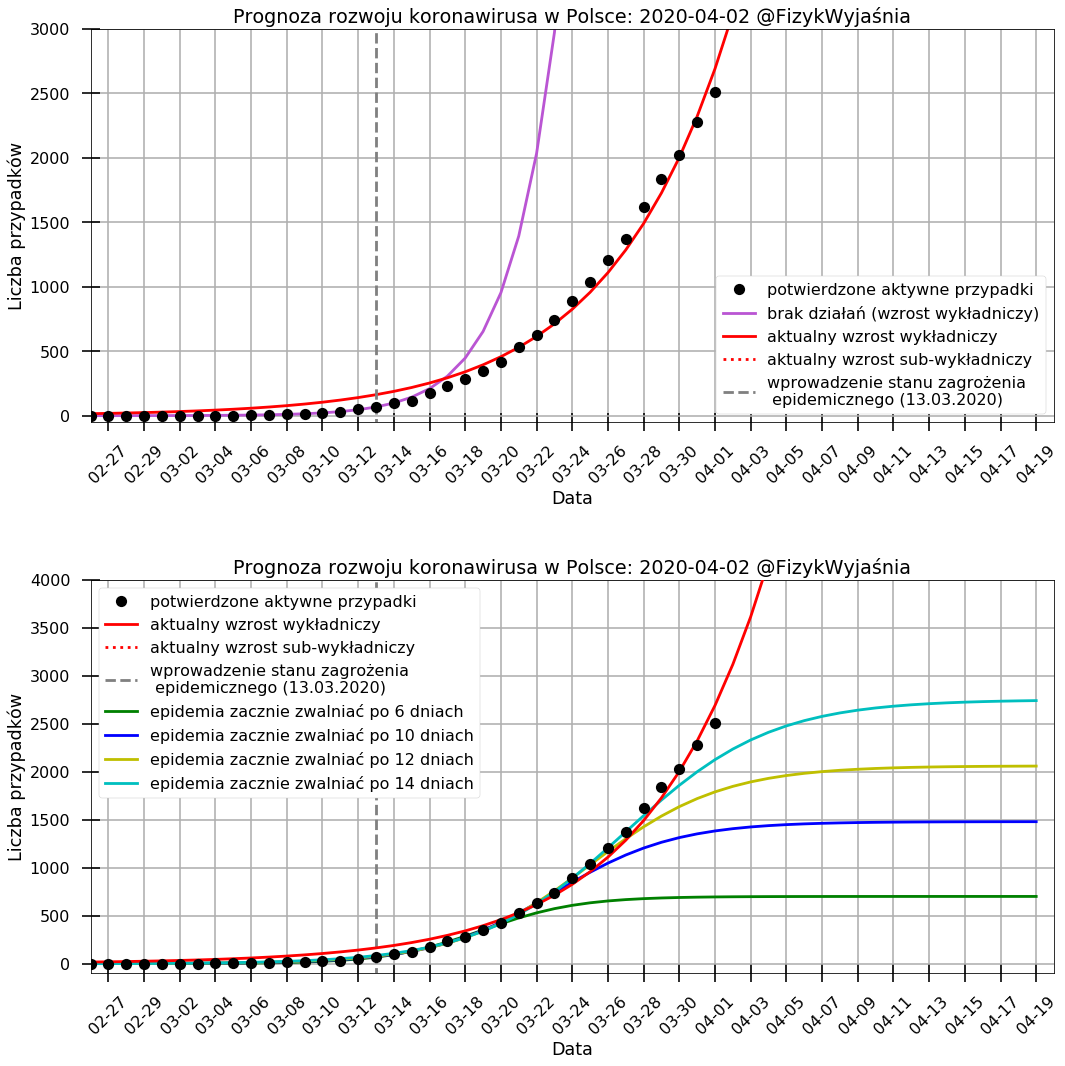

In [38]:
## Create figure and plot space
fig, (ax, ax2) = plt.subplots(2,1, figsize=(16, 16), )

marker = itertools.cycle(('o', 'v', '^', '<', '>', 's', 'p', 'P')) 
color = itertools.cycle(('k','mediumorchid','r', 'darkorange', 'g', 'b', 'y','c','m'))

title = "Prognoza rozwoju koronawirusa w Polsce: "+time.strftime("%Y-%m-%d")+" @FizykWyjaśnia"
x_label = "Data"
y_label = "Liczba przypadków"
shutdown_label="wprowadzenie stanu zagrożenia \n epidemicznego (13.03.2020)"


## Absolute values
unnorm=countries_populations[considered_countries["predict"]]/per_num
## Absolute zoom
col=next(color)
ax.plot(dates, pred_data*unnorm, marker=next(marker), linestyle='', label="potwierdzone aktywne przypadki", color=col, zorder=10)
col=next(color)
hist_exp_fit
ax.plot(mdates.num2date(dates_num_extrapolate+dates_start), hist_exp_fit*unnorm, color=col, label="brak działań (wzrost wykładniczy)")
col=next(color)
ax.plot(mdates.num2date(dates_num_extrapolate+dates_start), pred_exp_fit*unnorm, color=col, label="aktualny wzrost wykładniczy")
#col=next(color)
ax.plot(mdates.num2date(subexp_dates_num_extrapolate+dates_start), sub_exp_fit*unnorm, color=col, label="aktualny wzrost sub-wykładniczy", linestyle="dotted")
ax.axvline(date_shutdown, -10, 10000000, label=shutdown_label, linestyle='--', color='gray', )
    
ax.set(xlabel=x_label,
       ylabel=y_label,
       title=title)

marker = itertools.cycle(('o', 'v', '^', '<', '>', 's', 'p', 'P')) 
color = itertools.cycle(('k', 'r', 'g', 'b', 'y','c','darkorange'))

col=next(color)
ax2.plot(dates, pred_data*unnorm, marker=next(marker), linestyle='', label="potwierdzone aktywne przypadki", color=col, zorder=10)
col=next(color)
ax2.plot(mdates.num2date(dates_num_extrapolate+dates_start), pred_exp_fit*unnorm, color=col, label="aktualny wzrost wykładniczy", zorder=9)
ax2.plot(mdates.num2date(subexp_dates_num_extrapolate+dates_start), sub_exp_fit*unnorm, color=col, label="aktualny wzrost sub-wykładniczy", linestyle="dotted")
ax2.axvline(date_shutdown, -10, 10000000, label=shutdown_label, linestyle='--', color='gray', )

for variant_name in fit_variants:
    col=next(color)
    ax2.plot(mdates.num2date(dates_num_extrapolate+dates_start), pred_sig_fit_fixed[variant_name]*unnorm, color=col, label=variant_name)

#col=next(color)
#ax2.plot(mdates.num2date(dates_num_extrapolate+dates_start), pred_sig_fit*unnorm, color=col)

ax2.set(xlabel=x_label,
       ylabel=y_label,
       title=title)

## axes 
for axis in [ax, ax2]:
    ## Define the date format
    tick_spacing=2
    axis.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    date_form = DateFormatter("%m-%d")
    axis.xaxis.set_major_formatter(date_form)
    axis.xaxis.set_tick_params(rotation=45, direction="out")
    axis.tick_params(direction='inout', length=18, colors='k')

    
    #limits
    axis.set_xlim([datetime.date(2020, 2, 26), datetime.date.today() + datetime.timedelta(days=days_to_extrapolate)])# datetime.date(2020, 3, 15)])
    #axis.set_xlim([datetime.date(2020, 3, 18), datetime.date(2020, 3, 23)])
    maxy_multip=1.1

    if axis == ax:
        axis.set_ylim(-50,3000)
        #axis.set_ylim(-20,20000)
        #axis.set_ylim([-0.1*maxy_multip*np.max(pred_sig_fit),maxy_multip*np.max(pred_sig_fit)])
        #axis.set_ylim([-0.1*maxy_multip*np.max(pred_sig_fit),maxy_multip*np.max(pred_sig_fit)])
    else:
        axis.set_ylim(-100,4000)
        #axis.set_ylim(-100,8000)
        #axis.set_ylim([-0.1*maxy_multip*np.max(pred_sig_fit*unnorm),maxy_multip*np.max(pred_sig_fit*unnorm)])    
        
    legend = axis.legend(frameon=1, facecolor='white', framealpha=1)#, loc='upper left')
    axis.grid(True)
    #axis.set_yscale("log")

#    frame = legend.get_frame()
#    frame.set_facecolor('green')
#    frame.set_edgecolor('red')
#    frame.set_alpha(1)


fig.tight_layout(pad=5.0) 
plt.show()

timestamp=time.strftime("%Y_%m_%d")

#fig.savefig("./predictions_for_poland_figures/prognoza_"+timestamp+".png")

#print(mdates.num2date(dates_num_extrapolate[:51+1]+dates_start)[-1])


In [15]:
#Exponent predictions
for day, exp_value in zip(mdates.num2date(dates_num_extrapolate+dates_start),(pred_exp_fit*unnorm)):
    print(day, exp_value)

2020-01-22 00:00:00+00:00 0.08701205950750637
2020-01-23 00:00:00+00:00 0.10086174634706745
2020-01-24 00:00:00+00:00 0.11691588423214548
2020-01-25 00:00:00+00:00 0.13552535506125396
2020-01-26 00:00:00+00:00 0.1570968905132652
2020-01-27 00:00:00+00:00 0.182101961642398
2020-01-28 00:00:00+00:00 0.21108708342772245
2020-01-29 00:00:00+00:00 0.2446857594951249
2020-01-30 00:00:00+00:00 0.28363232807755556
2020-01-31 00:00:00+00:00 0.32877801183316074
2020-02-01 00:00:00+00:00 0.3811095223087857
2020-02-02 00:00:00+00:00 0.4417706256710851
2020-02-03 00:00:00+00:00 0.512087141049435
2020-02-04 00:00:00+00:00 0.5935959178585735
2020-02-05 00:00:00+00:00 0.6880784254341333
2020-02-06 00:00:00+00:00 0.7975996891217134
2020-02-07 00:00:00+00:00 0.9245534238130987
2020-02-08 00:00:00+00:00 1.0717143513756824
2020-02-09 00:00:00+00:00 1.2422988454334973
2020-02-10 00:00:00+00:00 1.440035228962242
2020-02-11 00:00:00+00:00 1.669245261134186
2020-02-12 00:00:00+00:00 1.934938594402954
2020-02-

2020-01-22 00:00:00+00:00 0.0 0.0 nan
2020-01-23 00:00:00+00:00 0.0 0.0 nan
2020-01-24 00:00:00+00:00 0.0 0.0 nan
2020-01-25 00:00:00+00:00 0.0 0.0 nan
2020-01-26 00:00:00+00:00 0.0 0.0 nan
2020-01-27 00:00:00+00:00 0.0 0.0 nan
2020-01-28 00:00:00+00:00 0.0 0.0 nan
2020-01-29 00:00:00+00:00 0.0 0.0 nan
2020-01-30 00:00:00+00:00 0.0 0.0 nan
2020-01-31 00:00:00+00:00 0.0 0.0 nan
2020-02-01 00:00:00+00:00 0.0 0.0 nan
2020-02-02 00:00:00+00:00 0.0 0.0 nan
2020-02-03 00:00:00+00:00 0.0 0.0 nan
2020-02-04 00:00:00+00:00 0.0 0.0 nan
2020-02-05 00:00:00+00:00 0.0 0.0 nan
2020-02-06 00:00:00+00:00 0.0 0.0 nan
2020-02-07 00:00:00+00:00 0.0 0.0 nan
2020-02-08 00:00:00+00:00 0.0 0.0 nan
2020-02-09 00:00:00+00:00 0.0 0.0 nan
2020-02-10 00:00:00+00:00 0.0 0.0 nan
2020-02-11 00:00:00+00:00 0.0 0.0 nan
2020-02-12 00:00:00+00:00 0.0 0.0 nan
2020-02-13 00:00:00+00:00 0.0 0.0 nan
2020-02-14 00:00:00+00:00 0.0 0.0 nan
2020-02-15 00:00:00+00:00 0.0 0.0 nan
2020-02-16 00:00:00+00:00 0.0 0.0 nan
2020-02-17 0

/Users/maciejj/anaconda3/envs/corona-vis/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/maciejj/anaconda3/envs/corona-vis/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/Users/maciejj/anaconda3/envs/corona-vis/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
/Users/maciejj/anaconda3/envs/corona-vis/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


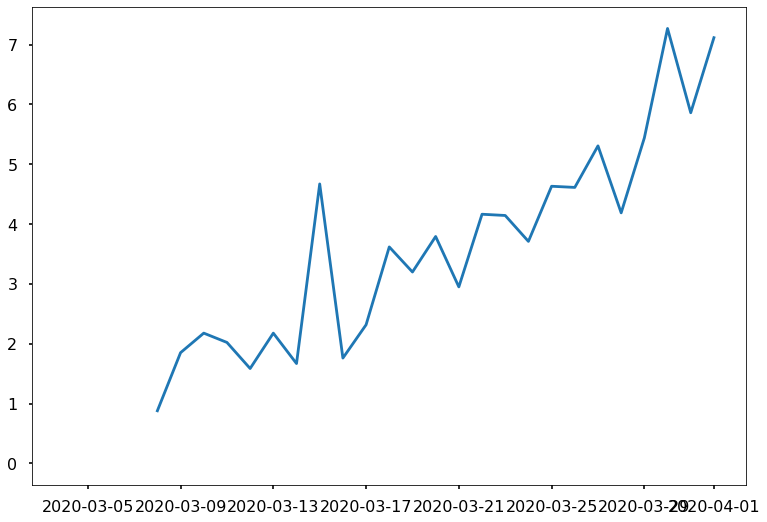

In [16]:
#data values difference and doubling time
doubling_time=[]
doubling_time_date=[]
for day, data_value, diff in zip(mdates.num2date(dates_num_extrapolate+dates_start), (pred_data*unnorm), 
                                 np.insert(np.diff(pred_data*unnorm),0,0)):
    print(day, np.round(data_value), np.round(diff), np.log(2)/np.log(data_value/(data_value-diff)))
    doubling_time.append(np.log(2)/np.log(data_value/(data_value-diff)))
    doubling_time_date.append(day)

    
print("Last day")
print(day, np.round(data_value), np.round(diff), np.log(2)/np.log(data_value/(data_value-diff)))

print("last 7 days")
print(np.mean(doubling_time[-7:]))

plt.plot(doubling_time_date, doubling_time)


In [17]:
#subexponent prediction
for day, sub_exp_value in zip(mdates.num2date(subexp_dates_num_extrapolate+dates_start), (sub_exp_fit*unnorm)):
    print(day, sub_exp_value)

2020-03-04 00:00:00+00:00 nan
2020-03-05 00:00:00+00:00 nan
2020-03-06 00:00:00+00:00 nan
2020-03-07 00:00:00+00:00 nan
2020-03-08 00:00:00+00:00 nan
2020-03-09 00:00:00+00:00 nan
2020-03-10 00:00:00+00:00 nan
2020-03-11 00:00:00+00:00 nan
2020-03-12 00:00:00+00:00 nan
2020-03-13 00:00:00+00:00 nan
2020-03-14 00:00:00+00:00 nan
2020-03-15 00:00:00+00:00 nan
2020-03-16 00:00:00+00:00 nan
2020-03-17 00:00:00+00:00 nan
2020-03-18 00:00:00+00:00 nan
2020-03-19 00:00:00+00:00 nan
2020-03-20 00:00:00+00:00 nan
2020-03-21 00:00:00+00:00 nan
2020-03-22 00:00:00+00:00 nan
2020-03-23 00:00:00+00:00 nan
2020-03-24 00:00:00+00:00 nan
2020-03-25 00:00:00+00:00 nan
2020-03-26 00:00:00+00:00 nan
2020-03-27 00:00:00+00:00 nan
2020-03-28 00:00:00+00:00 nan
2020-03-29 00:00:00+00:00 nan
2020-03-30 00:00:00+00:00 nan
2020-03-31 00:00:00+00:00 nan
2020-04-01 00:00:00+00:00 nan
2020-04-02 00:00:00+00:00 nan
2020-04-03 00:00:00+00:00 nan
2020-04-04 00:00:00+00:00 nan
2020-04-05 00:00:00+00:00 nan
2020-04-06